In [3]:
import os, random
import numpy as np
import torch

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: stronger determinism (may error if some ops are nondeterministic)
# torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Resample
Read Tamil from Kaggle input and save 16k audio to working directory

In [4]:
# =============================
# ✅ BLOCK 2: Resample Tamil dataset to 16k safely
# - Reads from /content/Tamil
# - Writes to /content/Tamil_16k
# =============================
import os, glob
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm

SRC_ROOT = "/kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Tamil/Tamil"
DST_ROOT = "/kaggle/working/Tamil_16k"
TARGET_SR = 16000

pairs = [
    (os.path.join(SRC_ROOT, "Depressed", "Train_set"),
     os.path.join(DST_ROOT, "Depressed", "Train_set")),
    (os.path.join(SRC_ROOT, "Non-depressed", "Train_set"),
     os.path.join(DST_ROOT, "Non-depressed", "Train_set")),
]

os.makedirs(DST_ROOT, exist_ok=True)

total = converted = same_sr = failed = 0

for src_dir, dst_dir in pairs:
    os.makedirs(dst_dir, exist_ok=True)

    files = glob.glob(os.path.join(src_dir, "**/*.wav"), recursive=True) + \
            glob.glob(os.path.join(src_dir, "**/*.WAV"), recursive=True)

    total += len(files)

    for fp in tqdm(files, desc=f"Resampling {os.path.basename(os.path.dirname(src_dir))}/{os.path.basename(src_dir)}"):
        try:
            y, sr = librosa.load(fp, sr=None, mono=True)

            # ✅ Trim silence (helps both MFCC + W2V2)
            y, _ = librosa.effects.trim(y, top_db=30)

            # ✅ Resample if needed
            if sr != TARGET_SR:
                y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
                converted += 1
            else:
                same_sr += 1

            # ✅ Safe RMS normalize (no noise blow-up like peak normalize)
            rms = float(np.sqrt(np.mean(y**2) + 1e-8))
            y = y / max(rms, 1e-3)
            y = np.clip(y, -1.0, 1.0)

            out_path = os.path.join(dst_dir, os.path.basename(fp))
            sf.write(out_path, y, TARGET_SR, subtype="PCM_16")

        except Exception as e:
            failed += 1

print("\n==== DONE ====")
print("Total files:", total)
print("Already 16k:", same_sr)
print("Resampled:", converted)
print("Failed:", failed)

# ✅ Quick verify SR
import random
check = glob.glob(os.path.join(DST_ROOT, "**/*.wav"), recursive=True)
sample = random.sample(check, min(20, len(check)))

srs = []
for fp in sample:
    _, sr = librosa.load(fp, sr=None, mono=True)
    srs.append(sr)

vals, cnts = np.unique(srs, return_counts=True)
print("New folder SR counts:", dict(zip(vals.tolist(), cnts.tolist())))
print("✅ New root:", DST_ROOT)


Resampling Non-depressed/Train_set: 100%|██████████| 920/920 [00:15<00:00, 57.53it/s]



==== DONE ====
Total files: 1374
Already 16k: 454
Resampled: 920
Failed: 0
New folder SR counts: {16000: 20}
✅ New root: /kaggle/working/Tamil_16k


# Build Metadata

Create CSV from resampled Tamil_16k with labels and speaker IDs

In [5]:
# =============================
# ✅ BLOCK 1: Build metadata CSV (from Tamil_16k)
# =============================
import os, glob, re
import pandas as pd

DATA_ROOT_16K = "/kaggle/working/Tamil_16k"

dep_train = os.path.join(DATA_ROOT_16K, "Depressed", "Train_set")
nd_train  = os.path.join(DATA_ROOT_16K, "Non-depressed", "Train_set")

import re, os

def extract_speaker_from_path(fp: str) -> str:
    base = os.path.splitext(os.path.basename(fp))[0]

    # Non-depressed: ND1, ND2...
    m = re.match(r"^(ND\d+)", base, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    # Depressed: D_<SPK>_... OR D_<SPK>-<rep>
    if base.startswith("D_"):
        rest = base[2:]                 # remove D_
        tok  = rest.split("_")[0]       # first token after D_
        tok  = re.sub(r"[-_][0-9a-zA-Z]+$", "", tok)  # remove trailing -3, _c, -2 etc.
        return tok.upper()

    # fallback
    tok = base.split("_")[0]
    tok = re.sub(r"[-_][0-9a-zA-Z]+$", "", tok)
    return tok.upper()

rows = []

def collect(folder, label):
    wavs = glob.glob(os.path.join(folder, "*.wav")) + glob.glob(os.path.join(folder, "*.WAV"))
    print(f"{folder} -> {len(wavs)} files")
    for f in wavs:
        fname = os.path.splitext(os.path.basename(f))[0]
        spk   = extract_speaker_from_path(f)
        rows.append({
            "file_path": f,
            "label": int(label),
            "fname": fname,
            "speaker": spk
        })

collect(dep_train, 1)
collect(nd_train, 0)

df = pd.DataFrame(rows)

print("\n✅ Total samples:", len(df))
print("✅ Label counts:\n", df["label"].value_counts())
print("✅ Unique speakers:", df["speaker"].nunique())
print("✅ Speakers per label:\n", df.groupby("label")["speaker"].nunique())

OUT_CSV = f"{DATA_ROOT_16K}/tamil_trainval_16k.csv"
df.to_csv(OUT_CSV, index=False)
print("\n✅ Saved:", OUT_CSV)

df.head()


/kaggle/working/Tamil_16k/Depressed/Train_set -> 454 files
/kaggle/working/Tamil_16k/Non-depressed/Train_set -> 920 files

✅ Total samples: 1374
✅ Label counts:
 label
0    920
1    454
Name: count, dtype: int64
✅ Unique speakers: 44
✅ Speakers per label:
 label
0     5
1    39
Name: speaker, dtype: int64

✅ Saved: /kaggle/working/Tamil_16k/tamil_trainval_16k.csv


,file_path,label,fname,speaker
0,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_F2001_b,F2001
1,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_F10021-1,F10021
2,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_F10013-4,F10013
3,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_28-2,S00
4,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_26-3,S00


# Speaker sanity check

In [6]:
import pandas as pd
import re

df = pd.read_csv("/kaggle/working/Tamil_16k/tamil_trainval_16k.csv")

print("Total rows:", len(df))
print("Unique speakers:", df["speaker"].nunique())
print("Speakers per label:\n", df.groupby("label")["speaker"].nunique())

# 1) Mixed-label speakers check (speaker leakage risk)
mix = df.groupby("speaker")["label"].nunique()
mixed = mix[mix > 1]
print("\nMixed-label speakers (should be 0):", len(mixed))
if len(mixed):
    print(mixed.head(20))

# 2) Show top speakers by #files (helps spot parsing bug)
print("\nTop 15 speakers by file-count:")
print(df["speaker"].value_counts().head(15))

# 3) Pattern check: speakers that look suspicious (not ND#, not S##, not F#### etc.)
def is_ok_spk(s):
    s = str(s)
    if re.fullmatch(r"ND\d+", s): return True
    if re.fullmatch(r"S\d+", s): return True          # S00, S01...
    if re.fullmatch(r"F\d+", s): return True          # F2006...
    if re.fullmatch(r"[A-Z]\d+", s): return True      # A1 type (just in case)
    return False

bad = df[~df["speaker"].apply(is_ok_spk)]
print("\nSuspicious speaker IDs:", bad["speaker"].nunique())
print(bad[["fname","speaker","label"]].head(30))

# 4) Depressed files where speaker still contains '-' or '_' at end (bad trimming)
bad_dep = df[(df["label"]==1) & (df["speaker"].str.contains(r"[-_]", regex=True))]
print("\nDepressed speakers containing '-' or '_' (should be 0 ideally):", bad_dep["speaker"].nunique())
print(bad_dep[["fname","speaker"]].head(30))


Total rows: 1374
Unique speakers: 44
Speakers per label:
 label
0     5
1    39
Name: speaker, dtype: int64

Mixed-label speakers (should be 0): 0

Top 15 speakers by file-count:
speaker
S00       241
ND3       184
ND1       184
ND2       184
ND4       184
ND5       184
A00        80
F10011      4
F10013      4
F20014      4
F10021      4
F2001       4
F1008       4
F2004       4
F20011      4
Name: count, dtype: int64

Suspicious speaker IDs: 0
Empty DataFrame
Columns: [fname, speaker, label]
Index: []

Depressed speakers containing '-' or '_' (should be 0 ideally): 0
Empty DataFrame
Columns: [fname, speaker]
Index: []


# Speaker Split

Speaker-stratified train/val split

In [7]:
# =============================
# ✅ BLOCK 3 (BEST): Speaker-stratified Train/Val split (safe + balanced)
# - VAL gets: 1 ND speaker + ~20% Dep speakers (min 2)
# - Deterministic (seed=42)
# Output: /content/Tamil_16k/tamil_trainval_16k_stratspk.csv
# =============================
import numpy as np
import pandas as pd

IN_CSV  = "/kaggle/working/Tamil_16k/tamil_trainval_16k.csv"
OUT_CSV = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"

df = pd.read_csv(IN_CSV)

# 0) Hard sanity: no mixed-label speakers
mix = df.groupby("speaker")["label"].nunique()
mixed = mix[mix > 1]
assert len(mixed) == 0, f"❌ Mixed-label speakers found: {len(mixed)}. Fix speaker parsing first."

# 1) Speaker -> label
spk_label = df.groupby("speaker")["label"].agg(lambda x: int(x.value_counts().idxmax())).reset_index()
dep_spk = spk_label[spk_label["label"] == 1]["speaker"].tolist()
nd_spk  = spk_label[spk_label["label"] == 0]["speaker"].tolist()

print("✅ Dep speakers:", len(dep_spk), "| ND speakers:", len(nd_spk))

# 2) Choose VAL speakers
rng = np.random.default_rng(42)

# ND speakers are only 5 -> keep VAL ND = 1 (best compromise)
n_nd_val = 1 if len(nd_spk) >= 2 else len(nd_spk)

# Dep speakers are many -> take 20% but at least 2
val_frac_dep = 0.20
n_dep_val = int(round(len(dep_spk) * val_frac_dep))
n_dep_val = max(2, n_dep_val) if len(dep_spk) >= 2 else len(dep_spk)

val_nd  = set(rng.choice(nd_spk,  size=n_nd_val, replace=False).tolist()) if n_nd_val > 0 else set()
val_dep = set(rng.choice(dep_spk, size=n_dep_val, replace=False).tolist()) if n_dep_val > 0 else set()

val_spk = val_nd | val_dep

# 3) Assign split
df["split"] = "train"
df.loc[df["speaker"].isin(val_spk), "split"] = "val"

# 4) Checks
print("\n✅ Split counts:\n", df["split"].value_counts())
print("\n✅ Label counts by split:\n", df.groupby(["split","label"]).size())
print("\n✅ Speakers by split:\n", df.groupby("split")["speaker"].nunique())

train_spk = set(df[df["split"]=="train"]["speaker"])
val_spk2  = set(df[df["split"]=="val"]["speaker"])
overlap = train_spk & val_spk2
print("\n✅ Speaker overlap (MUST be empty):", overlap)

assert len(overlap) == 0, "❌ Speaker leakage: overlap is NOT empty!"

# 5) Save
df.to_csv(OUT_CSV, index=False)
print("\n✅ Saved:", OUT_CSV)

print("\nVAL speakers (for record):", sorted(list(val_spk2)))


✅ Dep speakers: 39 | ND speakers: 5

✅ Split counts:
 split
train    1158
val       216
Name: count, dtype: int64

✅ Label counts by split:
 split  label
train  0        736
       1        422
val    0        184
       1         32
dtype: int64

✅ Speakers by split:
 split
train    35
val       9
Name: speaker, dtype: int64

✅ Speaker overlap (MUST be empty): set()

✅ Saved: /kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv

VAL speakers (for record): ['F10011', 'F10015', 'F10021', 'F10022', 'F1007', 'F2001', 'F20011', 'F20015', 'ND1']


# MFCC

In [8]:
import os, random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

# =============================
# 0) Reproducibility (IMPORTANT)
# =============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_PATH = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
SAVE_DIR = "/kaggle/working/models_tamil"
os.makedirs(SAVE_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# =============================
# 1) MFCC extraction
# =============================
def extract_mfcc(file_path, target_sr=16000, n_mfcc=40, max_len=320):
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)

    # (optional) trim silence to reduce padding waste (safe)
    y, _ = librosa.effects.trim(y, top_db=30)

    mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)  # [n_mfcc, T]

    # utterance-level CMVN (safe)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

    T = mfcc.shape[1]
    if T < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.astype(np.float32)

class TamilMFCCDataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df["split"] == split].reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = extract_mfcc(row["file_path"])
        y = int(row["label"])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

train_ds = TamilMFCCDataset(df, "train")
val_ds   = TamilMFCCDataset(df, "val")

# =============================
# 2) DataLoader (balanced sampling helps a lot)
# =============================
def seed_worker(worker_id):
    s = SEED + worker_id
    np.random.seed(s); random.seed(s)

g = torch.Generator()
g.manual_seed(SEED)

# WeightedRandomSampler for TRAIN only (handles skew better than only class weights)
train_labels = df[df["split"]=="train"]["label"].astype(int).values
class_counts = np.bincount(train_labels, minlength=2)          # [count0, count1]
class_weights = 1.0 / np.maximum(class_counts, 1)             # inverse freq
sample_weights = class_weights[train_labels]                  # per sample weight

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,              # ✅ use sampler instead of shuffle
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True
)

# =============================
# 3) Model
# =============================
class MFCC_CNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B,1,40,320]
        x = self.features(x)
        return self.classifier(x)

model = MFCC_CNN().to(device)

# Loss: still keep class weights (fine), even though sampler already helps
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
cw = torch.tensor(cw, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# LR scheduler improves stability

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)


# =============================
# 4) Eval
# =============================
def eval_macro_f1(model):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            pred = torch.argmax(logits, dim=1)
            ys.extend(y.cpu().numpy().tolist())
            ps.extend(pred.cpu().numpy().tolist())
    return f1_score(ys, ps, average="macro")

# =============================
# 5) Train with early stopping
# =============================
best_f1 = -1.0
best_state = None
patience = 6
bad = 0
EPOCHS = 30

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    val_f1 = eval_macro_f1(model)
    scheduler.step(val_f1)

    print(f"Epoch {epoch:02d} | train_loss={total_loss/len(train_loader):.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# Safety: best_state fallback
if best_state is None:
    print("⚠️ No improvement detected; saving last epoch weights.")
else:
    model.load_state_dict(best_state)

print("✅ Best MFCC val macro-F1:", best_f1)

mfcc_path = os.path.join(SAVE_DIR, "mfcc_cnn_tamil_16k_stratspk.pt")
torch.save(model.state_dict(), mfcc_path)
print("✅ Saved:", mfcc_path)


Epoch 01 | train_loss=0.5904 | val_macroF1=0.1350
Epoch 02 | train_loss=0.4274 | val_macroF1=0.7528
Epoch 03 | train_loss=0.2113 | val_macroF1=0.7673
Epoch 04 | train_loss=0.1635 | val_macroF1=0.8977
Epoch 05 | train_loss=0.1255 | val_macroF1=0.8815
Epoch 06 | train_loss=0.1163 | val_macroF1=0.8288
Epoch 07 | train_loss=0.1271 | val_macroF1=0.9242
Epoch 08 | train_loss=0.1024 | val_macroF1=0.8773
Epoch 09 | train_loss=0.0830 | val_macroF1=0.8403
Epoch 10 | train_loss=0.0921 | val_macroF1=0.8838
Epoch 11 | train_loss=0.0740 | val_macroF1=0.9113
Epoch 12 | train_loss=0.0671 | val_macroF1=0.8838
Epoch 13 | train_loss=0.0915 | val_macroF1=0.9185
Early stopping.
✅ Best MFCC val macro-F1: 0.9241543443486403
✅ Saved: /kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt


In [9]:
src = "/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt"
dst = "/kaggle/working/mfcc_cnn_tamil_16k_stratspk.pt"

# Wev2Vec2

In [10]:
# ============================================
# ✅ FULL W2V2 TRAIN (KAGGLE): Tamil 16k + speaker-safe split
# - Reads: /kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv
# - Saves: /kaggle/working/DDDL_Tamil_Models/wav2vec2_tamil_16k_stratspk/{stage1,stage2,final}
# ============================================

import os, random
import numpy as np
import pandas as pd
import torch, librosa
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# =============================
# 0) Seeds / deterministic
# =============================
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device)

# =============================
# 1) Paths (Kaggle)
# =============================
CSV_PATH   = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
SAVE_ROOT  = "/kaggle/working/DDDL_Tamil_Models"
W2V2_DIR   = os.path.join(SAVE_ROOT, "wav2vec2_tamil_16k_stratspk")
os.makedirs(W2V2_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("✅ CSV loaded:", CSV_PATH)
print(df["split"].value_counts())
print(df.groupby(["split","label"]).size())

# =============================
# 2) Feature extractor
# =============================
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    sampling_rate=16000
)

# =============================
# 3) Dataset + collate
# =============================
class TamilW2V2Dataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df["split"] == split].reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio, _ = librosa.load(row["file_path"], sr=16000, mono=True)
        audio, _ = librosa.effects.trim(audio, top_db=30)
        return {"input_values": audio, "labels": int(row["label"])}

train_ds = TamilW2V2Dataset(df, "train")
val_ds   = TamilW2V2Dataset(df, "val")

def collate_fn(batch):
    inputs = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    feats = feature_extractor(inputs, sampling_rate=16000, padding=True, return_tensors="pt")
    feats["labels"] = labels
    return feats

# =============================
# 4) Class weights
# =============================
train_labels = df[df["split"]=="train"]["label"].astype(int).values
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
cw = torch.tensor(cw, dtype=torch.float32)  # keep CPU; move to device inside loss
print("✅ class weights:", cw.tolist())

# =============================
# 5) Weighted Trainer (version-proof)
# =============================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        w = cw.to(logits.device)
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=w)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, preds, average="macro")}

# =============================
# 6) Build model
# =============================
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    num_labels=2,
    problem_type="single_label_classification"
).to(device)

# =============================
# STAGE 1: Freeze encoder
# =============================
for p in model.wav2vec2.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

args_stage1 = TrainingArguments(
    output_dir=os.path.join(W2V2_DIR, "stage1"),
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,

    learning_rate=5e-5,
    num_train_epochs=8,
    warmup_steps=50,
    weight_decay=0.01,

    fp16=torch.cuda.is_available(),   # Kaggle GPU হলে True, না হলে False
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
    remove_unused_columns=False
)

trainer1 = WeightedTrainer(
    model=model,
    args=args_stage1,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer1.train()
print("✅ Stage1 best F1:", trainer1.state.best_metric)

# =============================
# STAGE 2: Unfreeze last 2 layers (fp16 OFF for stability)
# =============================
for p in model.wav2vec2.parameters():
    p.requires_grad = False

for layer in model.wav2vec2.encoder.layers[-2:]:
    for p in layer.parameters():
        p.requires_grad = True

for p in model.classifier.parameters():
    p.requires_grad = True

args_stage2 = TrainingArguments(
    output_dir=os.path.join(W2V2_DIR, "stage2"),
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,

    learning_rate=1e-5,
    num_train_epochs=8,
    warmup_steps=30,
    weight_decay=0.01,

    fp16=False,                 # ✅ IMPORTANT
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
    remove_unused_columns=False
)

trainer2 = WeightedTrainer(
    model=model,
    args=args_stage2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer2.train()
print("✅ Stage2 best F1:", trainer2.state.best_metric)

# =============================
# 7) Save FINAL (Kaggle)
# =============================
FINAL_DIR = os.path.join(W2V2_DIR, "final")
os.makedirs(FINAL_DIR, exist_ok=True)

trainer2.model.save_pretrained(FINAL_DIR)
feature_extractor.save_pretrained(FINAL_DIR)

print("✅ Saved FINAL W2V2:", FINAL_DIR)

✅ device: cuda
✅ CSV loaded: /kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv
split
train    1158
val       216
Name: count, dtype: int64
split  label
train  0        736
       1        422
val    0        184
       1         32
dtype: int64


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

✅ class weights: [0.7866848111152649, 1.3720378875732422]


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/422 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-xls-r-300m
Key                          | Status     | 
-----------------------------+------------+-
project_q.weight             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 
projector.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,1.338652,0.679687,0.459222
2,1.164657,0.625779,0.583333
3,0.994102,0.610906,0.572073
4,0.867909,0.632854,0.549652


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Stage1 best F1: 0.5833333333333333


Epoch,Training Loss,Validation Loss,F1
1,1.000148,0.619076,0.568329
2,0.849592,0.688829,0.443728
3,0.706982,0.863712,0.314580


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Stage2 best F1: 0.5683288922725542


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved FINAL W2V2: /kaggle/working/DDDL_Tamil_Models/wav2vec2_tamil_16k_stratspk/final


# Ensemble Weight Tune

In [27]:
# ============================================================
# ✅ Ensemble Tune (Kaggle) — EXACT replica of your Colab code
# (same logic, only paths changed to Kaggle)
# ============================================================

import os, numpy as np, pandas as pd, torch, librosa
from sklearn.metrics import f1_score
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_PATH = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
df = pd.read_csv(CSV_PATH)

# =============================
# 1) MFCC model + extractor
# =============================
def extract_mfcc(file_path, target_sr=16000, n_mfcc=40, max_len=320):
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    T = mfcc.shape[1]
    if T < max_len:
        mfcc = np.pad(mfcc, ((0,0),(0, max_len-T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.astype(np.float32)

class MFCC_CNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.25),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        return self.classifier(x)

MFCC_PATH = "/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt"
mfcc_model = MFCC_CNN().to(device)
mfcc_model.load_state_dict(torch.load(MFCC_PATH, map_location="cpu"))
mfcc_model.eval()

# =============================
# 2) W2V2 model (load from FINAL, not checkpoint)
# =============================
W2V2_CKPT = "/kaggle/working/DDDL_Tamil_Models/wav2vec2_tamil_16k_stratspk/final"

# Feature extractor from base model (same as your code)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    sampling_rate=16000
)

w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(W2V2_CKPT).to(device)
w2v2_model.eval()

softmax = torch.nn.Softmax(dim=1)

@torch.no_grad()
def mfcc_prob(file_path):
    x = extract_mfcc(file_path)
    x = torch.from_numpy(x).unsqueeze(0).to(device)
    logits = mfcc_model(x)
    return softmax(logits).squeeze(0).cpu().numpy()

@torch.no_grad()
def w2v2_prob(file_path):
    audio, _ = librosa.load(file_path, sr=16000, mono=True)
    audio, _ = librosa.effects.trim(audio, top_db=30)
    feats = feature_extractor([audio], sampling_rate=16000, padding=True, return_tensors="pt")
    feats = {k: v.to(device) for k, v in feats.items()}
    logits = w2v2_model(**feats).logits
    return softmax(logits).squeeze(0).cpu().numpy()

# =============================
# 3) Tune ensemble weight on VAL
# =============================
val_df = df[df["split"]=="val"].reset_index(drop=True)
val_labels = val_df["label"].astype(int).values

val_m = []
val_w = []
for fp in val_df["file_path"].tolist():
    val_m.append(mfcc_prob(fp))
    val_w.append(w2v2_prob(fp))

val_m = np.stack(val_m)
val_w = np.stack(val_w)

best_w = None
best_f1 = -1

for w in np.linspace(0, 1, 101):
    p = w * val_m + (1 - w) * val_w
    preds = np.argmax(p, axis=1)
    f1 = f1_score(val_labels, preds, average="macro")
    if f1 > best_f1:
        best_f1 = f1
        best_w = float(w)

print("✅ Best MFCC weight:", best_w)
print("✅ Best ensemble VAL macro-F1:", best_f1)

# Save weight to Kaggle working
OUT_W = "/kaggle/working/best_ensemble_weight_tamil.txt"
with open(OUT_W, "w") as f:
    f.write(str(best_w))
print("✅ Saved best weight to:", OUT_W)

# Ready predictor
def ensemble_predict(file_path, w_mfcc=best_w):
    p1 = mfcc_prob(file_path)
    p2 = w2v2_prob(file_path)
    p = w_mfcc * p1 + (1 - w_mfcc) * p2
    return int(np.argmax(p)), p

Loading weights:   0%|          | 0/426 [00:00<?, ?it/s]

✅ Best MFCC weight: 0.64
✅ Best ensemble VAL macro-F1: 0.9333333333333333
✅ Saved best weight to: /kaggle/working/best_ensemble_weight_tamil.txt


# Ensemble

In [28]:
# ============================================================
# ✅ DD-DL FINAL PREDICTION (Tamil RUN2 - Ensemble, Kaggle)
# - Reads wavs directly from Kaggle input folder (no zip)
# - ensemble_predict() must be defined + models loaded before this cell
# ============================================================

import os, glob
import pandas as pd

TEAM_NAME = "TriVector"
RUN = "run2"

TEST_DIR = "/kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Test-set-tamil/Test-set-tamil"
SAVE_DIR = "/kaggle/working/submissions"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Collect wav files
wavs = glob.glob(os.path.join(TEST_DIR, "**", "*.wav"), recursive=True) + \
       glob.glob(os.path.join(TEST_DIR, "**", "*.WAV"), recursive=True)

assert len(wavs) > 0, f"❌ No wav found in: {TEST_DIR}"
wavs = sorted(wavs)
print("✅ Total test wavs:", len(wavs))

# 2) Predict (ensemble_predict MUST already be defined above)
def to_text_label(pred_int):
    return "Depressed" if int(pred_int) == 1 else "Non-depressed"

rows = []
for fp in wavs:
    pred, _ = ensemble_predict(fp)   # ✅ ensemble
    file_id = os.path.splitext(os.path.basename(fp))[0]
    rows.append({"file_name": file_id, "labels": to_text_label(pred)})

# 3) Save CSV
csv_name = f"{TEAM_NAME}_Tamil_{RUN}.csv"
csv_path = os.path.join(SAVE_DIR, csv_name)
pd.DataFrame(rows).to_csv(csv_path, index=False)

print("✅ Saved Tamil RUN2 CSV:", csv_path)
print(pd.read_csv(csv_path).head())

✅ Total test wavs: 160
✅ Saved Tamil RUN2 CSV: /kaggle/working/submissions/TriVector_Tamil_run2.csv
  file_name         labels
0        t1      Depressed
1       t10  Non-depressed
2      t100  Non-depressed
3      t101  Non-depressed
4      t102  Non-depressed


GT rows: 160 | Pred rows: 160 | Matched: 160
Sample GT ids: ['t1', 't2', 't3', 't4', 't5']
Sample Pred ids: ['t1', 't10', 't100', 't101', 't102']

📊 Classification Report:

               precision    recall  f1-score   support

Non-depressed     0.6723    1.0000    0.8040        80
    Depressed     1.0000    0.5125    0.6777        80

     accuracy                         0.7562       160
    macro avg     0.8361    0.7562    0.7409       160
 weighted avg     0.8361    0.7562    0.7409       160



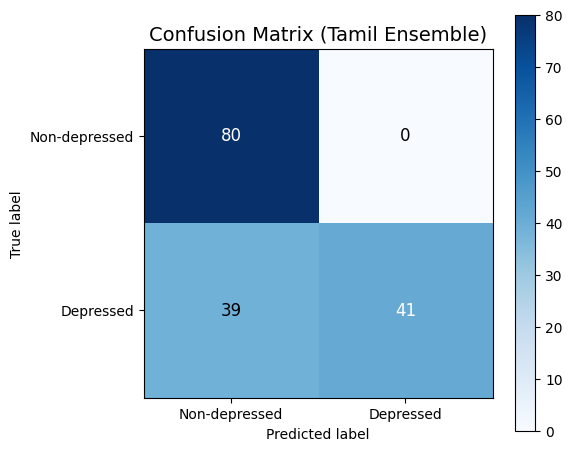

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

PRED_CSV = "/kaggle/working/submissions/TriVector_Tamil_run2.csv"
GT_CSV   = "/kaggle/input/datasets/tahmimahoque/depression-det/Tamil_GT.xlsx - tam.csv"

pred = pd.read_csv(PRED_CSV)
gt   = pd.read_csv(GT_CSV)

# --- normalize ids (strip .wav) ---
gt["id"] = gt["filename"].astype(str).str.replace(r"\.wav$", "", regex=True).str.replace(r"\.WAV$", "", regex=True)
pred["id"] = pred["file_name"].astype(str).str.replace(r"\.wav$", "", regex=True).str.replace(r"\.WAV$", "", regex=True)

# map GT labels D/ND -> text
gt["true"] = gt["label"].astype(str).str.strip().str.upper().map({"D":"Depressed", "ND":"Non-depressed"})

# prediction label column
pred = pred.rename(columns={"labels":"pred"})

df = gt[["id","true"]].merge(pred[["id","pred"]], on="id", how="inner")

print("GT rows:", len(gt), "| Pred rows:", len(pred), "| Matched:", len(df))
print("Sample GT ids:", gt["id"].head().tolist())
print("Sample Pred ids:", pred["id"].head().tolist())

# if still 0, show unmatched examples
if len(df) == 0:
    gt_set = set(gt["id"])
    pr_set = set(pred["id"])
    print("Example in GT not in Pred:", list(gt_set - pr_set)[:10])
    print("Example in Pred not in GT:", list(pr_set - gt_set)[:10])
    raise SystemExit("❌ Still 0 match. Check file naming.")

labels = ["Non-depressed", "Depressed"]

print("\n📊 Classification Report:\n")
print(classification_report(df["true"], df["pred"], labels=labels, digits=4, zero_division=0))

cm = confusion_matrix(df["true"], df["pred"], labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix (Tamil Ensemble)", fontsize=14)
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

thresh = cm.max()/2 if cm.max()>0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]),
                 ha="center", va="center",
                 fontsize=12,
                 color="white" if cm[i,j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()